<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/Bayesian/Bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.18.0
TFP version: 0.25.0


# Probabilistic layers and Bayesian neural networks

## Coding tutorials
#### [1. The DistributionLambda layer](#coding_tutorial_1)
#### [2. Probabilistic layers](#coding_tutorial_2)
#### [3. The DenseVariational layer](#coding_tutorial_3)
#### [4. Reparameterization layers](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## The `DistributionLambda` layer

In [ ]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

model = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=(2,)),
    tf_keras.layers.Dense(units=1),
    tfp.layers.DistributionLambda(make_distribution_fn=
        lambda t: tfp.distributions.Normal(loc=t, scale=1),
        convert_to_tensor_fn=tfp.distributions.Distribution.sample)
])
model.compile(
    loss=lambda y_true, y_pred: -y_pred.log_prob(value=y_true),
    optimizer=tf_keras.optimizers.RMSprop()
)

x_test = tf.random.normal(shape=(3, 2), dtype=tf.float32)
model(inputs=x_test).mean()

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-0.05583134],
       [-0.3238279 ],
       [-2.8974078 ]], dtype=float32)>

#### Create a probabilistic model using the `DistributionLambda` layer

Create a model whose first layer represents:

$$
y = \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$

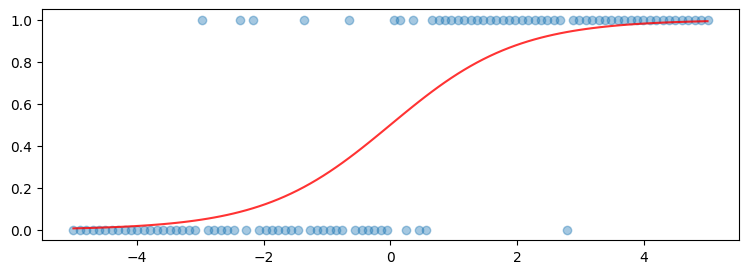

In [ ]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
tf.keras.utils.set_random_seed(seed=42)

# Create a sigmoid model, first deterministic, then probabilistic

model = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=(1,)),
    tf_keras.layers.Dense(units=1,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.constant_initializer(value=1),
        bias_initializer=tf.constant_initializer(value=0)),
    tfp.layers.DistributionLambda(make_distribution_fn=
        lambda t: tfp.distributions.Bernoulli(probs=t),
        convert_to_tensor_fn=tfp.distributions.Distribution.sample)
])

# Plot the function
x_plot = np.linspace(start=-5, stop=5, num=100, dtype=np.float32)
y_pred = model.predict(x=x_plot, verbose=False)
plt.figure(figsize=(9, 3))
plt.scatter(x=x_plot, y=y_pred.squeeze(), alpha=0.4)
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color="r", alpha=0.8)
plt.show()

In [ ]:
import numpy as np
np.random.seed(seed=42)

# Create a constant input for this model

x = np.array([0], dtype=np.float32)
x.shape

(1,)

In [ ]:
# Explore the feedforward object...

model(inputs=x)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1, 1] event_shape=[] dtype=int32>

In [ ]:
# ... and its behaviour under repeated calls

for _ in range(5):
    print(model.predict(x=x, verbose=False))

[[1]]
[[1]]
[[0]]
[[1]]
[[1]]


#### Use the forward model to create probabilistic training data

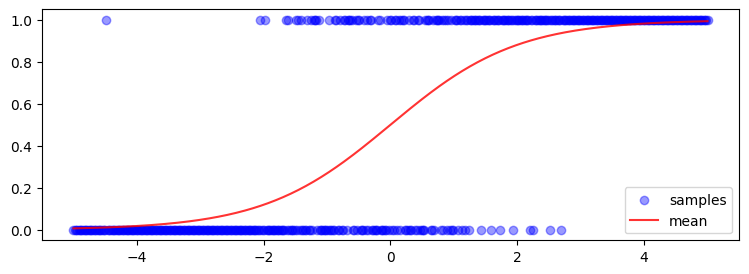

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
tf.keras.utils.set_random_seed(seed=42)

# Use the model to create 500 training points

x_train = np.linspace(start=-5, stop=5, num=500, dtype=np.float32)
y_train = model.predict(x=x_train, verbose=False)

# Plot the data and the mean of the distribution
fig, ax = plt.subplots(figsize=(9, 3))
ax.scatter(x=x_train, y=y_train.squeeze(), alpha=0.4,
    color='blue', label='samples')
ax.plot(x_train, tf.squeeze(model(inputs=x_train).mean()),
    color='red', alpha=0.8, label='mean')
ax.legend()
plt.show()

#### Create a new probabilistic model with the wrong weights

In [ ]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Create a new version of the model, with the wrong weights

model_untrained = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=(1,)),
    tf_keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.constant_initializer(value=2),
        bias_initializer=tf.constant_initializer(value=2)),
    tfp.layers.DistributionLambda(make_distribution_fn=
        lambda t: tfp.distributions.Bernoulli(probs=t),
        convert_to_tensor_fn=tfp.distributions.Distribution.sample)
])
model_untrained.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
 distribution_lambda_2 (Dis  ((None, 1),               0         
 tributionLambda)             (None, 1))                         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train the new model with the negative loglikelihood

In [ ]:
# Define negative loglikelihood, which we will use for training

def nll(y_true, y_pred):
    return -y_pred.log_prob(value=y_true)

In [ ]:
import tf_keras

# Compile untrained model

model_untrained.compile(
    loss=nll,
    optimizer=tf_keras.optimizers.RMSprop(learning_rate=0.01)
)

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

# Train model, record weights after each epoch

epochs = [0]
training_weights = [model_untrained.weights[0].numpy().squeeze()]
training_bias = [model_untrained.weights[1].numpy().squeeze()]
for epoch in range(100):
    model_untrained.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model_untrained.weights[0].numpy().squeeze())
    training_bias.append(model_untrained.weights[1].numpy().squeeze())

model_untrained.weights

[<tf.Variable 'dense_2/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.0866516]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.02019608], dtype=float32)>]

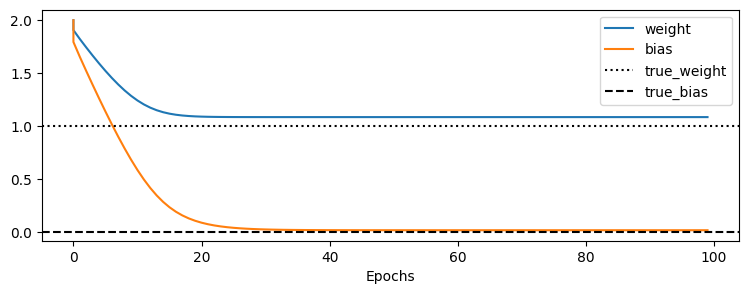

In [ ]:
import matplotlib.pyplot as plt

# Plot the model weights as they train,
# converging to the correct values

plt.figure(figsize=(9, 3))
plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='k', linestyle=':')
plt.axhline(y=0, label='true_bias', color='k', linestyle='--')
plt.xlabel(xlabel='Epochs')
plt.legend()
plt.show()

***
<a id="coding_tutorial_2"></a>
## Probabilistic layers

In [ ]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

model = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=(2,)),
    tf_keras.layers.Dense(units=16,
        activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=2), # (batch_size, 2)
    tfp.layers.DistributionLambda(make_distribution_fn=
        lambda t: tfp.distributions.Independent(distribution=
            tfp.distributions.Normal(loc=t[..., :1],
                scale=tf.math.softplus(t[..., 1:])),
        reinterpreted_batch_ndims=1))
])

x_sample = tf.random.normal(shape=(16, 2), dtype=tf.float32) # x_sample: (16, 2)
model(inputs=x_sample)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[16] event_shape=[1] dtype=float32>

In [ ]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

event_shape = (1,)
model = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=(2,)),
    tf_keras.layers.Dense(units=16,
        activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=tfp.layers.IndependentNormal.params_size(
        event_shape=event_shape)),
    tfp.layers.IndependentNormal(event_shape=event_shape,
        convert_to_tensor_fn=tfp.distributions.Distribution.sample)
])

x_sample = tf.random.normal(shape=(16, 2), dtype=tf.float32) # x_sample: (16, 2)
model(inputs=x_sample)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[16] event_shape=[1] dtype=float32>

In [ ]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

num_classes = 10
model = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=(32, 32, 3)),
    tf_keras.layers.Conv2D(filters=16, kernel_size=(3, 3),
        activation=tf.keras.activations.relu),
    tf_keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(units=64,
        activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=
        tfp.layers.OneHotCategorical.params_size(
            event_size=num_classes)),
    tfp.layers.OneHotCategorical(event_size=num_classes)
])

model.compile(
    loss=lambda y_true, y_pred: -y_pred.log_prob(value=y_true),
    optimizer=tf_keras.optimizers.Adam(learning_rate=0.01)
)

# x_test: (1, 32, 32, 3)
x_test = tf.random.normal(shape=(1, 32, 32, 3), dtype=tf.float32)
print('Mean:', model(inputs=x_test).mean())
print('Sample:', model(inputs=x_test).sample())

Mean: tf.Tensor(
[[0.12152483 0.16629434 0.00538378 0.01538067 0.01911224 0.15806192
  0.08608854 0.27489868 0.1167331  0.03652199]], shape=(1, 10), dtype=float32)
Sample: tf.Tensor([[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]], shape=(1, 10), dtype=float32)


#### Create data

The data you'll be working with is artifically created from the following equation:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

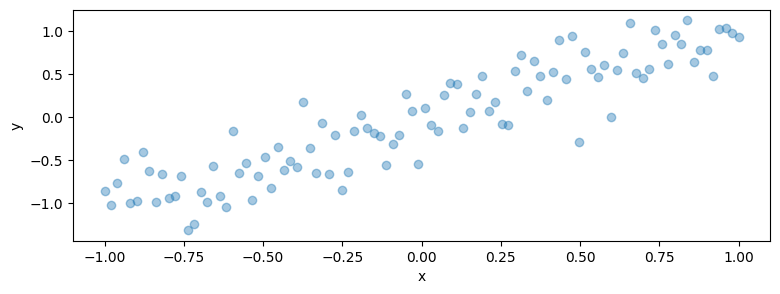

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=42)

#Create and plot 100 points of training data

x_train = np.linspace(start=-1, stop=1, num=100, dtype=np.float32)
y_train = x_train + 0.3*np.random.randn(100).astype(np.float32)

plt.figure(figsize=(9, 3))
plt.scatter(x=x_train, y=y_train, alpha=0.4)
plt.xlabel(xlabel='x')
plt.ylabel(ylabel='y')
plt.show()

#### Deterministic linear regression with MSE loss

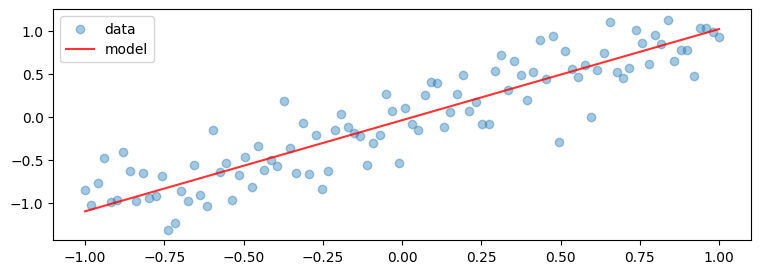

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
tf.keras.utils.set_random_seed(seed=42)

# Create and train deterministic linear model using mean squared error loss

# Create linear regression via Sequential model
model = tf.keras.Sequential(layers=[
    tf.keras.Input(shape=(1,)),
    tf.keras.layers.Dense(units=1)
])
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005))
model.fit(x=x_train, y=y_train, epochs=200, verbose=False)

# Plot the data and model
plt.figure(figsize=(9, 3))
plt.scatter(x=x_train, y=y_train, alpha=0.4, label='data')
y_pred = model.predict(x=x_train, verbose=False)
plt.plot(x_train, y_pred.squeeze(), color='red',
    alpha=0.8, label='model')
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Examine the model predictions

x = np.array([0], dtype=np.float32)
model(inputs=x)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.03775974]], dtype=float32)>

#### Probabilistic linear regression with both user-defined and learned variance

In [ ]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Create probabilistic regression with normal distribution as final layer

event_shape = 1
model = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=(1,)),
    tf_keras.layers.Dense(units=tfp.layers.IndependentNormal.params_size(
        event_shape=event_shape)),
    tfp.layers.IndependentNormal(event_shape=event_shape)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 4         
                                                                 
 independent_normal (Indepe  ((None, 1),               0         
 ndentNormal)                 (None, 1))                         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import tf_keras

# Train model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(value=y_true)

model.compile(
    loss=nll,
    optimizer=tf_keras.optimizers.RMSprop(learning_rate=0.005)
)
model.fit(x=x_train, y=y_train, epochs=200, verbose=False)

In [ ]:
# Examine the distribution created as a feedforward value

model(inputs=x)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[1] dtype=float32>

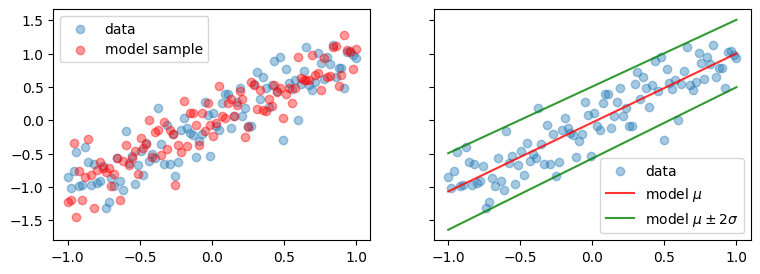

In [ ]:
import matplotlib.pyplot as plt

# Plot the data and a sample from the model

y_model = model(inputs=x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 3),
    sharey=True)
ax1.scatter(x=x_train, y=y_train, alpha=0.4, label='data')
ax1.scatter(x=x_train, y=y_sample, alpha=0.4, color='red',
    label='model sample')
ax1.legend()
ax2.scatter(x=x_train, y=y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8,
    label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

#### Probabilistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

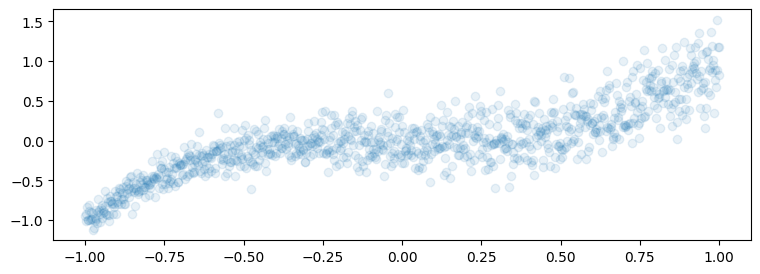

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=42)

# Create and plot 10000 data points

x_train = np.linspace(start=-1, stop=1, num=1000, dtype=np.float32)
y_train = np.power(x_train, 3) + 0.1*(2 + x_train)\
    *np.random.randn(1000).astype(np.float32)

plt.figure(figsize=(9, 3))
plt.scatter(x=x_train, y=y_train, alpha=0.1)
plt.show()

In [ ]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Create probabilistic regression: normal distribution with fixed variance

event_shape = 1
model = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=(1,)),
    tf_keras.layers.Dense(units=8,
        activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Dense(units=tfp.layers.IndependentNormal.params_size(
        event_shape=event_shape)),
    tfp.layers.IndependentNormal(event_shape=event_shape)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(value=y_true)

model.compile(
    loss=nll,
    optimizer=tf_keras.optimizers.RMSprop(learning_rate=0.01)
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 16        
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
 independent_normal (Indepe  ((None, 1),               0         
 ndentNormal)                 (None, 1))                         
                                                                 
Total params: 34 (136.00 Byte)
Trainable params: 34 (136.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train model
model.fit(x=x_train, y=y_train, epochs=500, verbose=False)
model.evaluate(x=x_train, y=y_train, verbose=False)

-0.2614278495311737

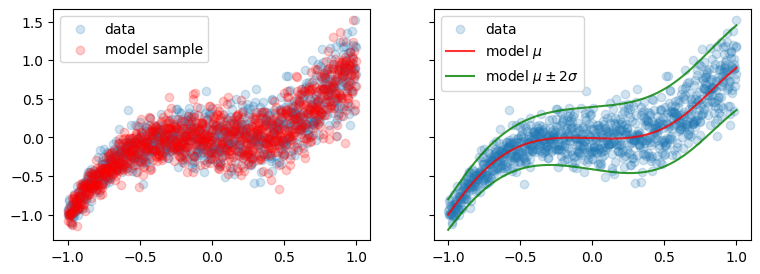

In [ ]:
import matplotlib.pyplot as plt

# Plot the data and a sample from the model

y_model = model(inputs=x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 3),
    sharey=True)
ax1.scatter(x=x_train, y=y_train, alpha=0.2, label='data')
ax1.scatter(x=x_train, y=y_sample, alpha=0.2, color='red',
    label='model sample')
ax1.legend()
ax2.scatter(x=x_train, y=y_train, alpha=0.2, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8,
    label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

***
<a id="coding_tutorial_3"></a>
## The `DenseVariational` layer

In [ ]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfp.distributions.Independent(distribution=
        tfp.distributions.Normal(scale=1, loc=tf.zeros(shape=n, dtype=dtype)),
        reinterpreted_batch_ndims=1)

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf_keras.Sequential(layers=[
        tfp.layers.VariableLayer(dtype=dtype,
            shape=tfp.layers.IndependentNormal.params_size(event_shape=n)),
        tfp.layers.IndependentNormal(event_shape=n,
            convert_to_tensor_fn=tfp.distributions.Distribution.sample)
    ])

# ELBO:
# q = q(w | theta)
# E_{w ~ q}[log p(D | w)] - KL[q || p]
#     = Sum_i E_{w ~ q}[log p(D_i | w)] - KL[q || p]

# For a minibatch:
# N/B * Sum_j E_{w ~ q}[log p(D_j | w)] - KL[q || p]

# Per example loss:
# 1/B * Sum_j E_{w ~q}[log p(D_j | w)] - 1/N * KL[q || p]

N=1000
model = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=(8,)),
    tfp.layers.DenseVariational(units=16,
        activation=tf.keras.activations.relu,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/N, kl_use_exact=True),
    tfp.layers.DenseVariational(units=2,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/N, kl_use_exact=True),
    tfp.layers.IndependentNormal(event_shape=1)
])

model.compile(
    loss=lambda y_true, y_pred: -y_pred.log_prob(value=y_true),
    optimizer=tf_keras.optimizers.RMSprop(learning_rate=0.005)
)

x_test = tf.random.uniform(shape=(2, 8), dtype=tf.float32)
model(inputs=x_test).mean()

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.2444477],
       [2.8562212]], dtype=float32)>

#### Create linear data with Gaussian noise

The data you'll be working with is the same as you used before:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed. We'll be running a Bayesian linear regression on this data.

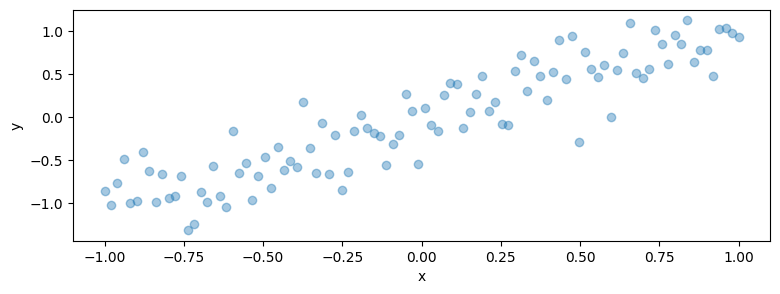

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=42)

# Use the same data as before -- create and plot 100 data points

x_train = np.linspace(start=-1, stop=1, num=100, dtype=np.float32)
y_train = x_train + 0.3*np.random.randn(100).astype(np.float32)

plt.figure(figsize=(9, 3))
plt.scatter(x=x_train, y=y_train, alpha=0.4)
plt.xlabel(xlabel='x')
plt.ylabel(ylabel='y')
plt.show()

#### Create the prior and posterior distribution for model weights

In [2]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf_keras.Sequential(layers=[
        tfp.layers.DistributionLambda(make_distribution_fn=
            lambda _: tfp.distributions.MultivariateNormalDiag(
                loc=tf.zeros(shape=n), scale_diag=tf.ones(shape=n)))
    ])
    return prior_model

In [3]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf_keras.Sequential(layers=[
        tfp.layers.VariableLayer(dtype=dtype,
            shape=tfp.layers.MultivariateNormalTriL.params_size(event_size=n)),
        tfp.layers.MultivariateNormalTriL(event_size=n)
    ])
    return posterior_model

#### Aside: analytical posterior

In this tutorial, we're using a variational posterior because, in most settings, it's not possible to derive an analytical one. However, in this simple setting, it is possible. Specifically, running a Bayesian linear regression on $x_i$ and $y_i$ with $i=1, \ldots, n$ and a unit Gaussian prior on both $\alpha$ and $\beta$:

$$
y_i = \alpha + \beta x_i + \epsilon_i, \quad
\epsilon_i \sim N(0, \sigma^2), \quad
\alpha \sim N(0, 1), \quad
\beta \sim N(0, 1)
$$

gives a multivariate Gaussian posterior on $\alpha$ and $\beta$:

$$
\begin{pmatrix}
\alpha \\
\beta
\end{pmatrix}
\sim
N(\mathbf{\mu}, \mathbf{\Sigma})
$$
where
$$
\mathbf{\mu}
=
\mathbf{\Sigma}
\begin{pmatrix}
\hat{n} \bar{y} \\
\hat{n} \overline{xy}
\end{pmatrix},
\quad
\mathbf{\Sigma} =
\frac{1}{(\hat{n} + 1)(\hat{n} \overline{x^2} + 1) - \hat{n}^2 \bar{x}^2}
\begin{pmatrix}
\hat{n} \overline{x^2} + 1 & -\hat{n} \bar{x} \\
-\hat{n} \bar{x} & \hat{n} + 1
\end{pmatrix}.
$$

In the above, $\hat{n} = \frac{n}{\sigma^2}$ and $\bar{t} = \frac{1}{n}\sum_{i=1}^n t_i$ for any $t$. In general, however, it's not possible to determine the analytical form for the posterior. For example, in models with a hidden layer with nonlinear activation function, the analytical posterior cannot be determined in general, and variational methods as below are useful.

#### Create the model with `DenseVariational` layers

In [5]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution

model = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=(1,)),
    tfp.layers.DenseVariational(units=1,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0], kl_use_exact=True)
])

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf_keras.optimizers.RMSprop(learning_rate=0.005)
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_1 (Dense  (None, 1)                 5         
 Variational)                                                    
                                                                 
Total params: 5 (20.00 Byte)
Trainable params: 5 (20.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train model and inspect

In [6]:
import tensorflow as tf

# Fit the model, just like a deterministic linear regression
model.fit(x=x_train, y=y_train, epochs=500, verbose=False)

In [16]:
import numpy as np

# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([0], dtype=np.float32)
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:           ', model_prior.mean().numpy())
print('prior variance:       ', model_prior.variance().numpy())
print('posterior mean:       ', model_posterior.mean().numpy())
print('posterior stddev:     ', model_posterior.stddev().numpy())
print('posterior covariance: ', model_posterior.covariance().numpy()[0])
print('                      ', model_posterior.covariance().numpy()[1])

prior mean:            [0. 0.]
prior variance:        [1. 1.]
posterior mean:        [ 1.01274   -0.0243581]
posterior stddev:      [0.1338573  0.08085433]
posterior covariance:  [0.01791777 0.00302092]
                       [0.00302092 0.00653742]


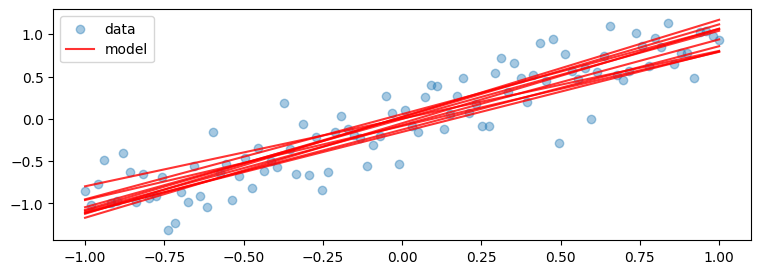

In [17]:
import matplotlib.pyplot as plt

# Plot an ensemble of linear regressions, with weights sampled from
# the posterior distribution

plt.figure(figsize=(9, 3))
plt.scatter(x=x_train, y=y_train, alpha=0.4, label='data')
for _ in range(10):
    y_model = model(inputs=x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8,
            label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)
plt.legend()
plt.show()

#### Explore the effect of sample size

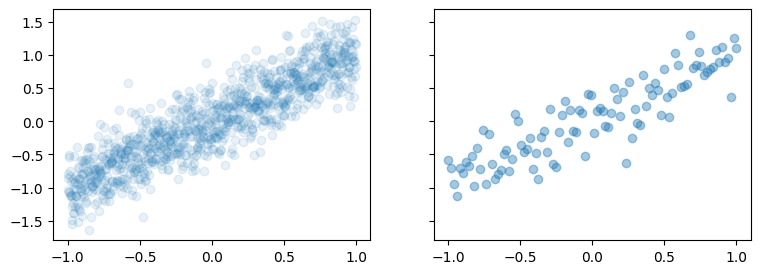

In [21]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=42)

# Create two datasets, one with 1000 points, another with 100

x_train_1000 = np.linspace(start=-1, stop=1, num=1000, dtype=np.float32)
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000).astype(np.float32)

x_train_100 = np.linspace(start=-1, stop=1, num=100, dtype=np.float32)
y_train_100 = x_train_100 + 0.3*np.random.randn(100).astype(np.float32)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 3),
    sharex=True, sharey=True)
ax1.scatter(x=x_train_1000, y=y_train_1000, alpha=0.1)
ax2.scatter(x=x_train_100, y=y_train_100, alpha=0.4)
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.utils.set_random_seed(seed=42)

# Train a model on each dataset

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(layers=[
        tfp.layers.DistributionLambda(make_distribution_fn=lambda t:
            tfp.distributions.MultivariateNormalDiag(
                loc=tf.zeros(shape=n), scale_diag=tf.ones(shape=n)))
    ])
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(layers=[
        tfp.layers.VariableLayer(shape=tfp.layers\
            .MultivariateNormalTriL.params_size(event_size=n),
        dtype=dtype),
        tfp.layers.MultivariateNormalTriL(event_size=n)])
    return posterior_model

model_1000 = tf.keras.Sequential(layers=[
    tfp.layers.DenseVariational(input_shape=(1,), units=1,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/1000)])

model_100 = tf.keras.Sequential(layers=[
    tfp.layers.DenseVariational(input_shape=(1,), units=1,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/100)])

model_1000.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005)
)
model_100.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005)
)

tf.random.set_seed(seed=42)
model_1000.fit(x=x_train_1000, y=y_train_1000, epochs=50,
    verbose=False)
model_100.fit(x=x_train_100, y=y_train_100, epochs=500,
    verbose=False)

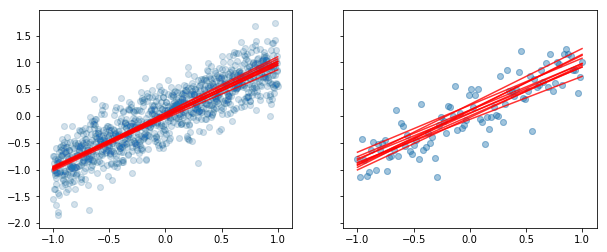

In [ ]:
import matplotlib.pyplot as plt

# Plot an ensemble of linear regressions from each model

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 3),
    sharex=True, sharey=True)

for _ in range(10):
    y_model_1000 = model_1000(inputs=x_train_1000)
    ax1.scatter(x=x_train_1000, y=y_train_1000, color='C0',
        alpha=0.02)
    ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)
    y_model_100 = model_100(inputs=x_train_100)
    ax2.scatter(x=x_train_100, y=y_train_100, color='C0', alpha=0.05)
    ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)

plt.show()

#### Put it all together: nonlinear probabilistic regression with weight uncertainty

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

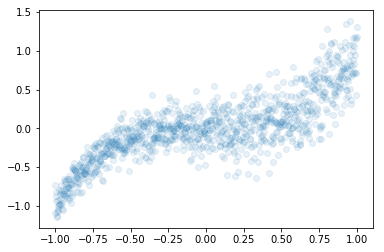

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create and plot 1000 data points

x_train = np.linspace(start=-1, stop=1, num=1000)[:, np.newaxis]
y_train = np.power(x_train, 3) \
    + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x=x_train, y=y_train, alpha=0.1)
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

# Create probabilistic regression with one hidden layer, weight uncertainty

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(layers=[
        tfp.layers.DistributionLambda(make_distribution_fn=lambda t:
            tfp.distributions.MultivariateNormalDiag(
                loc=tf.zeros(shape=n), scale_diag=tf.ones(shape=n)))
    ])
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(layers=[
        tfp.layers.VariableLayer(shape=tfp.layers\
            .MultivariateNormalTriL.params_size(event_size=n),
        dtype=dtype),
        tfp.layers.MultivariateNormalTriL(event_size=n)])
    return posterior_model

model = tf.keras.Sequential(layers=[
    tfp.layers.DenseVariational(units=8, input_shape=(1,),
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0],
        activation=tf.keras.activations.sigmoid),

    tfp.layers.DenseVariational(
        units=tfp.layers.IndependentNormal.params_size(event_shape=1),
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0]),

    tfp.layers.IndependentNormal(event_shape=1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(value=y_true)

model.compile(
    loss=nll,
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005)
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_2 (DenseVa (None, 8)                 152       
_________________________________________________________________
dense_variational_3 (DenseVa (None, 2)                 189       
_________________________________________________________________
independent_normal_1 (Indepe ((None, 1), (None, 1))    0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf

# Train the model
tf.random.set_seed(seed=42)
model.fit(x=x_train, y=y_train, epochs=1000, verbose=False)
model.evaluate(x=x_train, y=y_train)

1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0543


0.054296646177768706

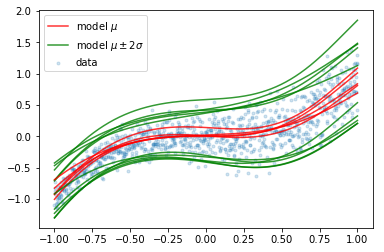

In [ ]:
import matplotlib.pyplot as plt

# Plot an ensemble of trained probabilistic regressions

plt.scatter(x=x_train, y=y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
    y_model = model(inputs=x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8,
            label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8,
            label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
plt.legend()
plt.show()

***
<a id="coding_tutorial_4"></a>
## Reparameterization layers

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

def custom_multivariate_normal_fn(dtype, shape, name, trainable,
    add_variable_fn):
    normal = tfp.distributions.Normal(
        loc=tf.zeros(shape=shape, dtype=dtype),
        scale=2 * tf.ones(shape=shape, dtype=dtype))
    batch_ndims = tf.size(input=normal.batch_shape_tensor())
    return tfp.distributions.Independent(distribution=normal,
        reinterpreted_batch_ndims=batch_ndims)

dataset_size = 1000
model = tf.keras.Sequential(layers=[
    tfp.layers.Convolution2DReparameterization(
        input_shape=(28, 28, 1), filters=16, kernel_size=[3, 3],
        activation=tf.keras.activations.relu,
        kernel_prior_fn=custom_multivariate_normal_fn,
        kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
        kernel_posterior_tensor_fn=tfp.distributions\
            .Distribution.sample,
        kernel_divergence_fn=(lambda q, p, _: tfp.distributions
            .kl_divergence(distribution_a=q, distribution_b=p)\
            / dataset_size),
        bias_prior_fn=None,
        bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(
            is_singular=True),
        bias_posterior_tensor_fn=tfp.distributions\
            .Distribution.sample
    ),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3)),
    tf.keras.layers.Flatten(),
    tfp.layers.DenseReparameterization(units=
        tfp.layers.OneHotCategorical.params_size(event_size=10)),
    tfp.layers.OneHotCategorical(event_size=10)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_1  (None, 26, 26, 16)        304       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_reparameterization_1 ( (None, 10)                20490     
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 10), (None, 10))  0         
Total params: 20,794
Trainable params: 20,794
Non-trainable params: 0
_________________________________________________________________


#### Load in the HAR dataset

You'll be working with the [Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. It consists of the readings from an accelerometer (which measures acceleration) carried by a human doing different activities. The six activities are walking horizontally, walking upstairs, walking downstairs, sitting, standing and laying down. The accelerometer is inside a smartphone, and, every 0.02 seconds (50 times per second), it takes six readings: linear and gyroscopic acceleration in the x, y and z directions. See [this link](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) for details and download. If you use it in your own research, please cite the following paper:

- Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

The goal is to use the accelerometer data to predict the activity.

In [ ]:
import numpy as np
import os

# Load the HAR dataset and create some data processing functions

# Function to load the data from file
def load_HAR_data():
    data_dir = 'data/HAR/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs',
    2: 'walking downstairs', 3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0],
        data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(data_integer=y_train)
y_test_oh = integer_to_onehot(data_integer=y_test)

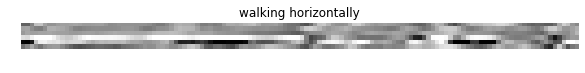

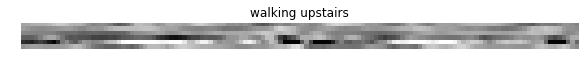

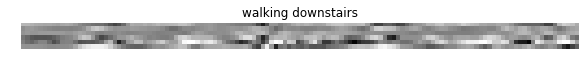

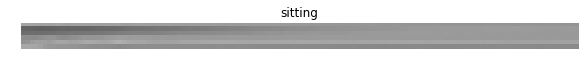

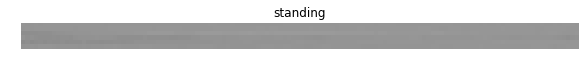

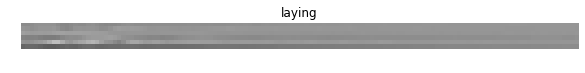

In [ ]:
import matplotlib.pyplot as plt

# Inspect some of the data by making plots

def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0]==label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(X=x_label[100*i].T, cmap='Greys',
                vmin=-1, vmax=1)
            ax.axis('off')
            if i==0:
                ax.set_title(label=label_to_activity[label])
    plt.show()

make_plots(num_examples_per_category=1)

#### 1D deterministic convolutional neural network

In [ ]:
import tensorflow as tf

# Create standard deterministic model with:
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense with Softmax

model = tf.keras.Sequential(layers=[
    tf.keras.layers.Conv1D(input_shape=(128, 6), filters=8,
        kernel_size=16, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling1D(pool_size=16),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=6,
        activation=tf.keras.activations.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


#### Probabilistic 1D convolutional neural network, with both weight and output uncertainty

In [ ]:
import tensorflow as tf

# Replace analytical Kullback-Leibler divergence with approximated one

def kl_approx(q, p, q_tensor):
    return tf.math.reduce_mean(input_tensor=
        q.log_prob(value=q_tensor) - p.log_prob(value=q_tensor))

divergence_fn = lambda q, p, q_tensor: kl_approx(
    q=q, p=p, q_tensor=q_tensor) / x_train.shape[0]

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

# Create probablistic model with the following layers:
#  - Conv1D
#  - MaxPooling
#  - Flatten
#  - Dense
#  - OneHotCategorical

divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(
    distribution_a=q, distribution_b=p) / x_train.shape[0]

model = tf.keras.Sequential(layers=[
    tfp.layers.Convolution1DReparameterization(
        input_shape=(128, 6), filters=8, kernel_size=16,
        activation=tf.keras.activations.relu,
        kernel_prior_fn=tfp.layers.default_multivariate_normal_fn,
        kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(
            is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
        bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(
            is_singular=False),
        bias_divergence_fn=divergence_fn
    ),
    tf.keras.layers.MaxPooling1D(pool_size=16),
    tf.keras.layers.Flatten(),
    tfp.layers.DenseReparameterization(
        units=tfp.layers.OneHotCategorical.params_size(event_size=6),
        activation=None,
        kernel_prior_fn=tfp.layers.default_multivariate_normal_fn,
        kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(
            is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
        bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(
            is_singular=False),
        bias_divergence_fn=divergence_fn
    ),
    tfp.layers.OneHotCategorical(event_size=6)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_1  (None, 113, 8)            1552      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 8)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_reparameterization_1 ( (None, 6)                 684       
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 6), (None, 6))    0         
Total params: 2,236
Trainable params: 2,236
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf

# Compile the model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(value=y_true)

model.compile(
    loss=nll,
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
    experimental_run_tf_function=False
)

In [ ]:
import tensorflow as tf

# Train the model

tf.random.set_seed(seed=42)
model.fit(x=x_train, y=y_train_oh, epochs=20, verbose=False)
model.evaluate(x=x_train, y=y_train_oh)
model.evaluate(x=x_test, y=y_test_oh)

2947/2947 [==============================] - 1s 172us/sample - loss: 0.9848 - categorical_accuracy: 0.6790


[0.9848295624352408, 0.6789956]

#### Inspect model performance

In [ ]:
import matplotlib.pyplot as plt

# Define function to analyse model predictions versus true labels

def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(X=x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(inputs=x_test[image_num]
            [np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(a=predicted_probabilities[:, i],
        q=2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(a=predicted_probabilities[:, i],
        q=97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(x=np.arange(6), height=pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(x=np.arange(6), height=pct_2p5-0.02, color='white',
        linewidth=1, edgecolor='white')
    ax.set_xticklabels(labels=[''] + [activity for activity in
        label_to_activity.values()], rotation=45,
        horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel(ylabel='Probability')
    plt.show()

------------------------------
Accelerometer data:


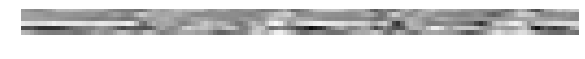

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


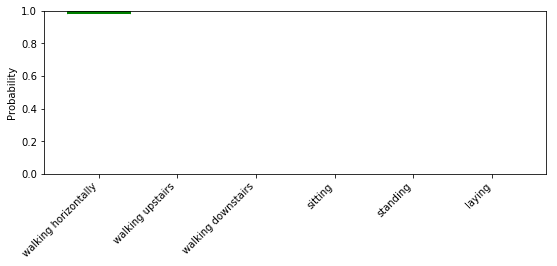

In [ ]:
analyse_model_predictions(image_num=79)

------------------------------
Accelerometer data:


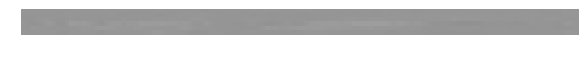

------------------------------
True activity: standing

------------------------------
Model estimated probabilities:


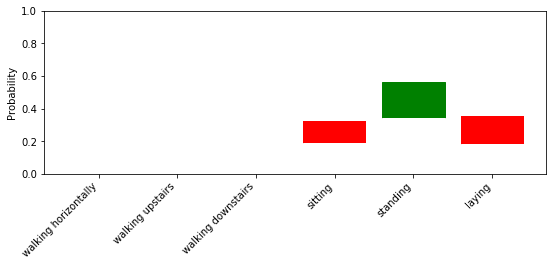

In [ ]:
analyse_model_predictions(image_num=633)

------------------------------
Accelerometer data:


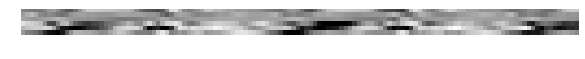

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


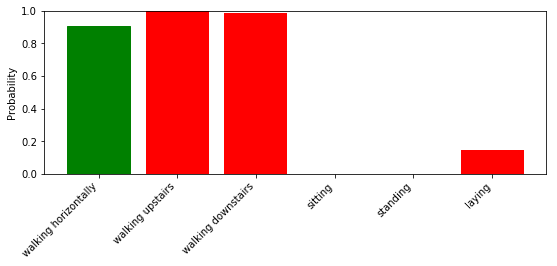

In [ ]:
analyse_model_predictions(image_num=1137)